In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quadrature
import tensorflow as tf

2022-10-28 18:45:03.645104: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
redshifts = np.loadtxt("/store/ska/sk09/segunet/test/lc_redshifts.txt", dtype = float)
redshifts.shape, redshifts[0], redshifts[-1]

((552,), 7.0, 11.018195)

In [3]:
def one_over_E(z, OMm):
    return 1 / np.sqrt(OMm * (1.0 + z) ** 3 + (1 - OMm))

def multiplicative_factor(z, OMm):
    return (1/one_over_E(z, OMm)/(1 + z)*quadrature(lambda x: one_over_E(x, OMm), 0, z)[0])

def calculate_k_cube(HII_DIM, chunk_length, cell_size):
    k = np.fft.fftfreq(HII_DIM, d=cell_size)
    k_parallel = np.fft.fftfreq(chunk_length, d=cell_size)
    delta_k = k_parallel[1] - k_parallel[0]
    k_cube = np.meshgrid(k, k, k_parallel)
    return tf.constant(k_cube, dtype = tf.float32), tf.constant(delta_k, dtype = tf.float32)

def calculate_blackman(chunk_length, delta_k):
    bm = np.abs(np.fft.fft(np.blackman(chunk_length))) ** 2
    buffer = delta_k * (np.where(bm / np.amax(bm) <= 1e-10)[0][0] - 1)
    BM = np.blackman(chunk_length)[np.newaxis, np.newaxis, :]
    return tf.constant(BM, dtype = tf.complex64), tf.constant(buffer, dtype = tf.float32)

def wedge_removal_tf(OMm, redshifts, HII_DIM, cell_size, Box, chunk_length=501, blackman=True, MF = None, k_cube_data = None, blackman_data = None, extreme=False, zero_padding=True):
    # zero padding: padds with zeros if True, otherwise with the flipped data
    # extreme takes the highest wedge in the data and cuts it out for all redsgifts
    # here we allow to pass multiplicative factor, k_cube_data, blackman_data, just so that it is not constantly re-computed
    
    permute = [2, 0, 1]
    inverse_permute = [1, 2, 0]
    
    if chunk_length % 2 == 0:
        chunk_length += 1
    
    if MF is None:
        MF = tf.constant([multiplicative_factor(z, OMm) for z in redshifts], dtype = tf.float32)
    # Box = tf.constant(Box, dtype = tf.float32)
    Box_uv = tf.transpose(tf.cast(Box, tf.complex64), perm = permute)
    Box_uv = tf.signal.fft2d(Box_uv)
    Box_uv = tf.transpose(Box_uv, perm = inverse_permute)

    if k_cube_data is None:
        k_cube, delta_k = calculate_k_cube(HII_DIM, chunk_length, cell_size)
    else:
        k_cube, delta_k = k_cube_data

    if blackman_data is None:
        BM, buffer = calculate_blackman(chunk_length, delta_k) 
    else:
        BM, buffer = blackman_data

    box_shape = Box_uv.shape
    # Box_final = np.empty(box_shape, dtype=np.float32)
    Box_final = []
    if zero_padding:
        pad = tf.zeros(k_cube[0].shape, dtype = tf.complex64)
        Box_uv = tf.concat([pad, Box_uv, pad], axis=2)
    else:
        pad1 = Box_uv[..., :HII_DIM][..., ::-1]
        pad2 = Box_uv[..., -HII_DIM:][..., ::-1]
        Box_uv = tf.concat([pad1, Box_uv, pad2], axis = 2)

    for i in range(chunk_length, box_shape[-1] + chunk_length):
        t_box = Box_uv[..., i - chunk_length // 2 : i + chunk_length // 2 + 1]
        mf = MF[-1] if extreme else MF[tf.math.minimum(i - chunk_length // 2 - 1, box_shape[-1] - 1)]
        W = k_cube[2] / (tf.math.sqrt(k_cube[0] ** 2 + k_cube[1] ** 2) * mf + buffer)
        w = tf.cast(tf.math.logical_or(W < -1.0, W > 1.0), tf.complex64)
        # w = cp.array(W[i + chunk_length - 1])
        if blackman is True:
            t_box = t_box * BM
        Box_final.append(tf.math.real(tf.signal.ifft3d(tf.signal.fft(t_box) * w)[..., chunk_length // 2]))

    return tf.transpose(tf.convert_to_tensor(Box_final), perm = inverse_permute).numpy()

In [4]:
OMm = 0.27
HII_DIM = 128
chunk_length = 129
cell_size = 2.0

In [6]:
MF = tf.constant([multiplicative_factor(z, OMm) for z in redshifts], dtype = tf.float32)
k_cube, delta_k = calculate_k_cube(HII_DIM, chunk_length, cell_size)
BM, buffer = calculate_blackman(chunk_length, delta_k)

In [7]:
def wedge_slope(k_par, z, theta = np.pi / 2, OMm = 0.27, HII_DIM = 200, cell_size = 1.5, buffer_threshold = 1e-10):
    """Computing the wedge slope of k_par giver k_perp.
    
    Args:
        k_par (array or float): k_par values for which the slope is computed
        z (float): redshift of the slope
        theta (float): angle used for sin(theta) pre-factor, use pi/2 for Horizon wedge.
        OMm (float): Omega matter, used for calculating the slope
        
        HII_DIM, cell_size and buffer_threshold : used only for calculating the buffer.
            One could also just specify the buffer, but here it is just to match previous function directly.
            
    Returns:
        k_perp (array or float): k_perp values
        buffer (float): the buffer value
    """

    def one_over_E(z, OMm):
        return 1 / np.sqrt(OMm * (1 + z) ** 3 + (1 - OMm))

    def multiplicative_factor(z, OMm):
        return 1 / one_over_E(z, OMm) / (1 + z) * quadrature(lambda x: one_over_E(x, OMm), 0, z)[0]

    MF = multiplicative_factor(z, OMm)

    k = 2 * np.pi * np.fft.fftfreq(HII_DIM, d=cell_size)
    delta_k = k[1] - k[0]
    bm = np.abs(np.fft.fft(np.blackman(HII_DIM))) ** 2
    buffer = delta_k * (np.where(bm / np.amax(bm) <= buffer_threshold)[0][0] - 1)

    
    k_par = np.sin(theta) * MF * k_perp + buffer

    return k_par, buffer

In [8]:
lc = np.load("/store/ska/sk09/test_wedge/dT2_21cm_i0.npy")
lc_fg_noise = np.load("/store/ska/sk09/test_wedge/dT4_21cm_i0.npy")
fg = np.load("/store/ska/sk09/test_wedge/dTfrg_21cm_i0.npy")

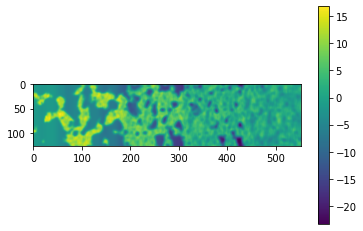

In [9]:
plt.imshow(lc[0])
plt.colorbar()

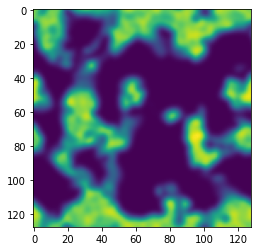

In [10]:
plt.imshow(lc[..., 100])

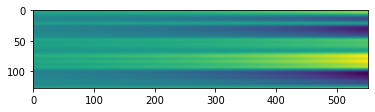

In [11]:
plt.imshow(lc_fg_noise[0])

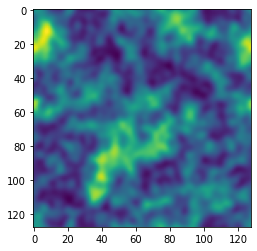

In [12]:
plt.imshow(lc_fg_noise[..., 100])

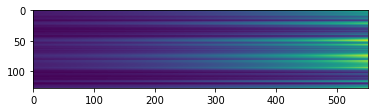

In [13]:
plt.imshow(fg[0])

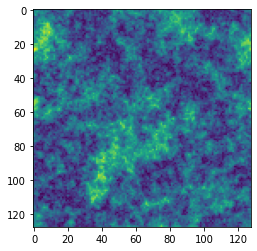

In [14]:
plt.imshow(fg[..., 100])

In [15]:
lc_fg_noise_cleaned = wedge_removal_tf(OMm, redshifts, HII_DIM, cell_size, tf.constant(lc_fg_noise, dtype=tf.float32), chunk_length, blackman = True, MF = MF, k_cube_data = (k_cube, delta_k), blackman_data = (BM, buffer), extreme=False, zero_padding=False)

2022-10-28 18:46:57.780953: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-10-28 18:46:58.326474: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-10-28 18:46:58.797619: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


In [17]:
lc_cleaned = wedge_removal_tf(
    OMm,
    redshifts,
    HII_DIM,
    cell_size,
    tf.constant(lc, dtype = tf.float32),
    chunk_length,
    blackman = True,
    MF = MF,
    k_cube_data = (k_cube, delta_k),
    blackman_data = (BM, buffer),
    extreme=True,
    zero_padding=False,
)

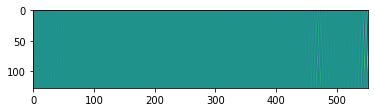

In [18]:
plt.imshow(lc_fg_noise_cleaned[0])

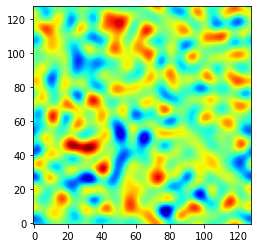

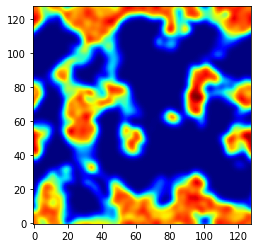

(None, None)

<Figure size 432x288 with 0 Axes>

In [25]:
plt.imshow(lc_fg_noise_cleaned[..., 100], cmap='jet', origin='lower')
plt.show(), plt.clf()

plt.imshow(lc[..., 100], cmap='jet', origin='lower')
plt.show(), plt.clf()


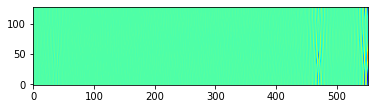

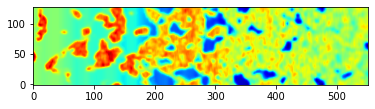

(None, None)

<Figure size 432x288 with 0 Axes>

In [27]:
plt.imshow(lc_fg_noise_cleaned[100], cmap='jet', origin='lower')
plt.show(), plt.clf()

plt.imshow(lc[100], cmap='jet', origin='lower')
plt.show(), plt.clf()

In [68]:
def ps2D(lc, cell_size, redshifts=None, n_psbins_par=12, n_psbins_perp=12, logk=True, convert_to_delta=True, chunk_skip=None, compute_variance=False, nanmask=None):
    """Calculating 2D PS for a series of redshifts for one lightcone.

    Args:
        lc (array): lightcone.
        redshifts (list): list of redshifts for which the lightcone has been computed. If `None`, redshifts will not be outputted.
        cell_size (float): simulation voxel size (in Mpc).
        n_psbins_par (int): number of PS bins in LoS direction.
        n_psbins_perp (int): number of PS bins in sky-plane direction.
        logk (bool): if `True` the binning is logarithmic, otherwise it is linear.
        convert_to_delta (bool): either to convert from power to non-dimensional delta.
        chunk_skip (int): in redshift dimension of the lightcone,
            PS is calculated on chunks `chunk_skip` apart.
            Eg. `chunk_skip = 2` amounts in taking every second redshift bin
            into account. If `None`, it amounts to the lightcone sky-plane size.
        compute_variance (bool): Either to compute variance in each PS bin or not.
        nanmask (array): mask defining which parts of the lightcone (in u, v, z coordinates)
            are measured and which are not, i.e. NaNs. Ignored in the case of `None`.

    Returns:
        PS (dict or array): power spectrum and its sample variance for all redshift bins.
            If `convert_to_delta is True`, returns `{"delta": array, "var_delta": array}`,
            otherwise, returns `{"power": array, "var_power": array}`.
            Moreover, if `compute_variance is False`, only "delta" or "power" array is returned.
        k_values_perp (array): centers of k_perp bins.
        k_values_par (array): centers of k_par bins.
        zs: redshifts, only if `redshifts` were given.
    """
    PS, k_values_perp, k_values_par, zs = _power_2D(lc, redshifts=redshifts, cell_size=cell_size, n_psbins_par=n_psbins_par, n_psbins_perp=n_psbins_perp, logk=logk, chunk_skip=chunk_skip, nanmask=nanmask, compute_variance=compute_variance)

    # TODO: correct the dimension of the meshgrid
    if convert_to_delta is True:
        k_values_cube = np.meshgrid(k_values_par, k_values_perp)  # all k_values on the 2D grid
        conversion_factor = (k_values_cube[1] ** 2 * k_values_cube[0]) / (4 * np.pi**2)  # pre-factor k_perp**2 * k_par
        conversion_factor = conversion_factor[np.newaxis, ...]
    else:
        conversion_factor = 1

    if compute_variance:
        PS_out = {"delta": PS["power"] * conversion_factor, "var_delta": PS["var_power"] * conversion_factor**2}
    else:
        PS_out = PS["power"] * conversion_factor

    if redshifts is None:
        return PS_out, k_values_perp, k_values_par
    else:
        return PS_out, k_values_perp, k_values_par, zs


# TODO: calculate mean values of ks in the code, not as geometrical mean
def _power_2D(lightcone, redshifts, cell_size, n_psbins_par, n_psbins_perp, logk, chunk_skip, nanmask, compute_variance):
    HII_DIM = lightcone.shape[0]
    n_slices = lightcone.shape[-1]
    chunk_skip = HII_DIM if chunk_skip is None else chunk_skip
    chunk_indices = list(range(0, n_slices + 1 - HII_DIM, chunk_skip))
    print(chunk_indices,  n_slices + 1 - HII_DIM, chunk_skip)
    epsilon = 1e-12

    # DFT frequency modes
    k = np.fft.fftfreq(HII_DIM, d=cell_size)
    k = 2 * np.pi * k
    # ignoring 0 and negative modes
    k_min, k_max = k[1], np.abs(k).max()
    # maximal perp mode will be k_max * sqrt(2)
    if logk:
        k_bins_perp = np.logspace(np.log10(k_min - epsilon), np.log10(np.sqrt(2.0) * k_max + epsilon), n_psbins_perp + 1)
 
        # maximal par mode will be k_max
        k_bins_par = np.logspace(np.log10(k_min - epsilon), np.log10(k_max + epsilon), n_psbins_par + 1)
    else:
        k_bins_perp = np.linspace(k_min - epsilon, k_max + epsilon, n_psbins_perp + 1)
        k_bins_par = np.linspace(k_min - epsilon, k_max + epsilon, n_psbins_par + 1)

    # grid of all k_values, where k_cube[0], k_cube[1] are perp values, and k_cube[2] par values
    k_cube = np.meshgrid(k, k, k)
    
    # calculating k_perp, k_par in cylindrical coordinates
    k_cylinder = [np.sqrt(k_cube[0] ** 2 + k_cube[1] ** 2), np.abs(k_cube[2])]
    
    # return a bin index across flattened k_cylinder, for perp and par
    k_perp_digits = np.digitize(k_cylinder[0].flatten(), k_bins_perp)
    k_par_digits = np.digitize(k_cylinder[1].flatten(), k_bins_par)
    
    # construct a unique digit counter for a 2D PS array
    # for first k_perp uses range [1, n_psbins_par]
    # for second k_perp uses range [n_psbins_par + 1, 2 * n_psbins_par] etc.
    k_cylinder_digits = (k_perp_digits - 1) * n_psbins_par + k_par_digits

    # now cut out outsiders: zeros, n_psbins_par + 1, n_psbins_perp + 1
    k_cylinder_digits = np.where(np.logical_or(k_perp_digits == 0, k_par_digits == 0), 0, k_cylinder_digits)
    k_cylinder_digits = np.where(np.logical_or(k_perp_digits == n_psbins_perp + 1, k_par_digits == n_psbins_par + 1), n_psbins_perp * n_psbins_par + 1, k_cylinder_digits)
    k_binsum = np.bincount(k_cylinder_digits, minlength=n_psbins_par * n_psbins_perp + 2)[1:-1]
    
    # geometrical means for values
    k_values_perp = np.sqrt(k_bins_perp[:-1] * k_bins_perp[1:])
    k_values_par = np.sqrt(k_bins_par[:-1] * k_bins_par[1:])

    lightcones = []  # all chunks that need to be computed
    nanmasks = []
    zs = []  # all redshifts that will be xomputed

    # appending all chunks together
    for i in chunk_indices:
        start = i
        end = i + HII_DIM
        lightcones.append(lightcone[..., start:end])
        if nanmask is not None:
            nanmasks.append(nanmask[..., start:end])
        if redshifts is not None:
            zs.append(redshifts[(start + end) // 2])

    V = (HII_DIM * cell_size) ** 3
    dV = cell_size**3

    def _power(box):
        FT = np.fft.fftn(box) * dV
        PS_box = np.real(FT * np.conj(FT)) / V

        # calculating average power as a bin count with PS as weights
        p = (np.bincount(k_cylinder_digits, weights=PS_box.flatten(), minlength=n_psbins_par * n_psbins_perp + 2,)[1:-1] / k_binsum).reshape(n_psbins_perp, n_psbins_par)

        # calculating average square of the power, used for estimating sample variance
        if compute_variance:
            p_sq = (np.bincount(k_cylinder_digits, weights=PS_box.flatten() ** 2, minlength=n_psbins_par * n_psbins_perp + 2,)[1:-1] / k_binsum).reshape(n_psbins_perp, n_psbins_par)
            return dict(power=p, var_power=p_sq - p**2)
        else:
            return dict(power=p, var_power=np.zeros(p.shape))

    def _power_nanmask(box, nanm):
        FT = np.fft.fft2(box, axes=(0, 1))
        FT = np.where(nanm, FT, np.nan)
        FT = np.fft.fft(FT, axis=-1) * dV
        PS_box = np.real(FT * np.conj(FT)) / V
        nans = np.isnan(PS_box)

        k_nan_binsum = np.bincount(k_cylinder_digits, weights=(~nans.flatten()).astype(np.float32), minlength=n_psbins_par * n_psbins_perp + 2)[1:-1]
        PS_box = np.where(nans, 0.0, PS_box)

        # calculating average power as a bin count with PS as weights
        p = (np.bincount(k_cylinder_digits, weights=PS_box.flatten(), minlength=n_psbins_par * n_psbins_perp + 2)[1:-1] / k_nan_binsum).reshape(n_psbins_perp, n_psbins_par)
        
        # calculating average square of the power, used for estimating sample variance
        if compute_variance:
            p_sq = (np.bincount(k_cylinder_digits, weights=PS_box.flatten()** 2, minlength=n_psbins_par * n_psbins_perp + 2)[1:-1] / k_nan_binsum).reshape(n_psbins_perp, n_psbins_par)
            return dict(power=p, var_power=p_sq - p**2)
        else:
            return dict(power=p, var_power=np.zeros(p.shape))

    if nanmask is not None:
        res = [_power_nanmask(lcs, nms) for lcs, nms in zip(lightcones, nanmasks)]
    else:
        res = [_power(lcs) for lcs in lightcones]

    res = {k: np.stack([o[k] for o in res], axis=0) for k in res[0].keys()}
    return res, k_values_perp, k_values_par, zs

In [69]:
ps_lc_fg_noise_cleaned, k_values_perp, k_values_par, zs = ps2D(lc_fg_noise_cleaned, cell_size=cell_size, redshifts=redshifts, n_psbins_par=12, n_psbins_perp=12, logk=False, convert_to_delta=False,chunk_skip=None, compute_variance=False, nanmask=None)
ps_lc_cleaned, k_values_perp, k_values_par, zs = ps2D(lc_cleaned, cell_size=cell_size, redshifts=redshifts, n_psbins_par=12, n_psbins_perp=12, logk=False, convert_to_delta=False, chunk_skip=None, compute_variance=False, nanmask=None)
ps_lc_fg_noise, k_values_perp, k_values_par, zs = ps2D(lc_fg_noise, cell_size = cell_size, redshifts=redshifts, n_psbins_par=12, n_psbins_perp=12, logk=False, convert_to_delta=False,chunk_skip=None, compute_variance=False, nanmask=None)
ps_lc, k_values_perp, k_values_par, zs = ps2D(lc, cell_size = cell_size, redshifts=redshifts, n_psbins_par=12, n_psbins_perp=12, logk=False, convert_to_delta=False,chunk_skip=None, compute_variance=False, nanmask=None)
ps_fg, k_values_perp, k_values_par, zs = ps2D(fg, cell_size = cell_size, redshifts=redshifts, n_psbins_par=12, n_psbins_perp=12, logk=False, convert_to_delta=False,chunk_skip=None, compute_variance=False, nanmask=None)

[0, 128, 256, 384] 425 128
[0, 128, 256, 384] 425 128
[0, 128, 256, 384] 425 128
[0, 128, 256, 384] 425 128
[0, 128, 256, 384] 425 128


In [31]:
k_perp = np.linspace(0, 1, 100)
k_par, buffer = wedge_slope(k_perp, z = redshifts[HII_DIM], theta = np.pi / 2)

In [32]:
zs

[7.353722, 8.135057, 9.031023, 10.065304]

In [65]:
import scipy 
dTfrg_sb = lc_fg_noise_cleaned[...,100:179]
BH = np.load('/store/ska/sk09/test_wedge/BM79_scipy.npy')
dTfrg_BH = dTfrg_sb * BH
sub_redshifts = redshifts[100:179]

ps_lc_fg_noise_cleaned, k_values_perp, k_values_par, zs = ps2D(dTfrg_BH, cell_size=cell_size, redshifts=sub_redshifts, n_psbins_par=12, n_psbins_perp=12, logk=False, convert_to_delta=False,chunk_skip=None, compute_variance=False, nanmask=None)

plt.imshow(np.log10(ps_lc_fg_noise_cleaned[0].T), origin = "lower", vmin=-1, vmax=7, interpolation="none", extent=[k_values_perp[0], k_values_perp[-1], k_values_par[0], k_values_par[-1]])
plt.colorbar(label = "$\log_{10} \, \Delta(k_{perp}, k_{par})$")
plt.plot(k_perp, k_par, color = "red")
plt.xlabel("$k_{perp}$")
plt.ylabel("$k_{par}$")
plt.xscale('log'), plt.yscale('log')
plt.xlim(k_values_perp[0], k_values_perp[-1])
plt.ylim(k_values_par[0], k_values_par[-1])

(128, 128, 79)
[]
[]
(0,)


IndexError: list index out of range

(0.06135923151400898, 1.504990732120426)

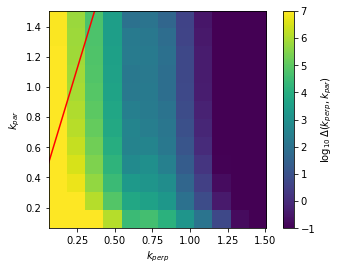

In [23]:
plt.imshow(np.log10(ps_lc_fg_noise[0].T), origin = "lower", vmin = -1, vmax = 7, interpolation="none", extent=[k_values_perp[0], k_values_perp[-1], k_values_par[0], k_values_par[-1]])
plt.colorbar(label = "$\log_{10} \, \Delta(k_{perp}, k_{par})$")
plt.plot(k_perp, k_par, color = "red")
plt.xlabel("$k_{perp}$")
plt.ylabel("$k_{par}$")
plt.xlim(k_values_perp[0], k_values_perp[-1])
plt.ylim(k_values_par[0], k_values_par[-1])

(0.06135923151400898, 1.504990732120426)

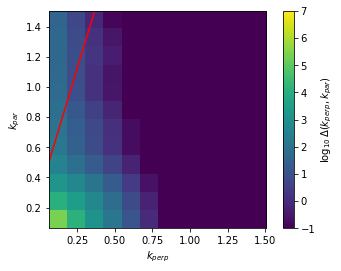

In [24]:
plt.imshow(np.log10(ps_lc[0].T), origin = "lower", vmin = -1, vmax = 7, interpolation="none", extent=[k_values_perp[0], k_values_perp[-1], k_values_par[0], k_values_par[-1]])
plt.colorbar(label = "$\log_{10} \, \Delta(k_{perp}, k_{par})$")
plt.plot(k_perp, k_par, color = "red")
plt.xlabel("$k_{perp}$")
plt.ylabel("$k_{par}$")
plt.xlim(k_values_perp[0], k_values_perp[-1])
plt.ylim(k_values_par[0], k_values_par[-1])

(0.06135923151400898, 1.504990732120426)

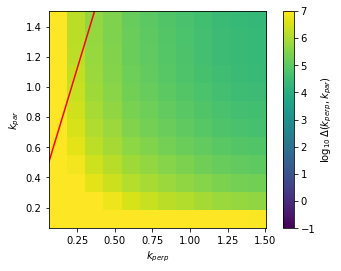

In [25]:
plt.imshow(np.log10(ps_fg[0].T), origin = "lower", vmin = -1, vmax = 7, interpolation="none", extent=[k_values_perp[0], k_values_perp[-1], k_values_par[0], k_values_par[-1]])
plt.colorbar(label = "$\log_{10} \, \Delta(k_{perp}, k_{par})$")
plt.plot(k_perp, k_par, color = "red")
plt.xlabel("$k_{perp}$")
plt.ylabel("$k_{par}$")
plt.xlim(k_values_perp[0], k_values_perp[-1])
plt.ylim(k_values_par[0], k_values_par[-1])

In [26]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

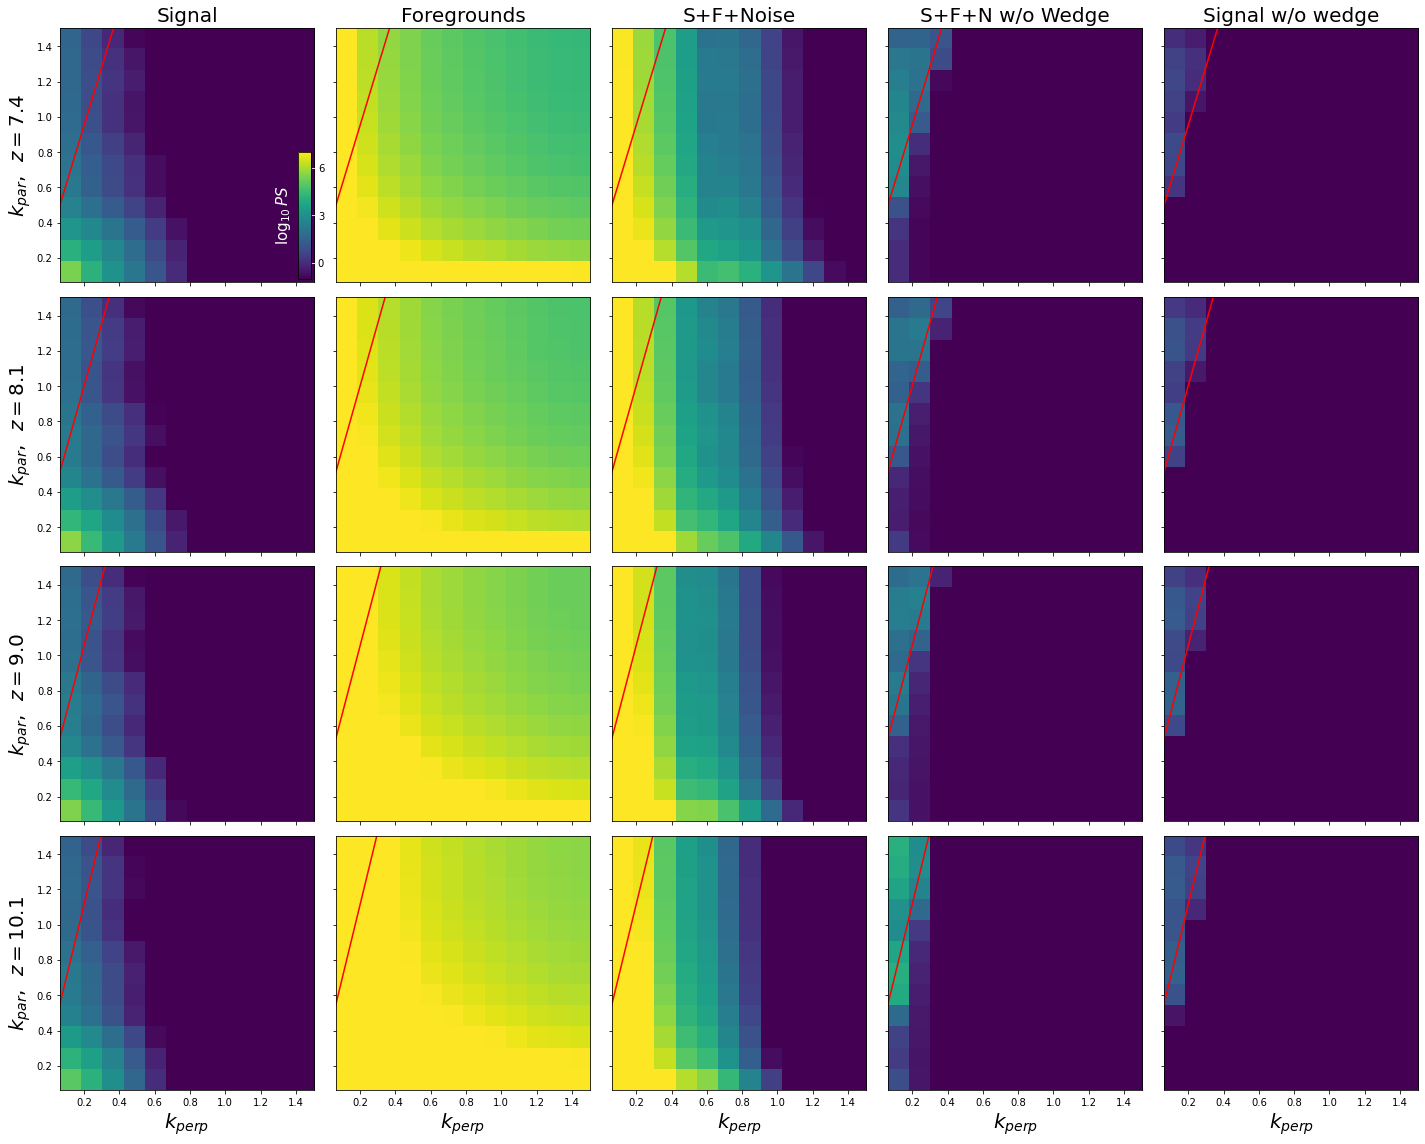

In [27]:
fig, axs = plt.subplots(4, 5, sharex = True, sharey = True, figsize = (20, 16))
for i, z in zip(range(4), zs):
    k_par, buffer = wedge_slope(k_perp, z = redshifts[(i + 1) * HII_DIM - 1], theta = np.pi / 2)
    for j, (ps, title) in enumerate(zip([ps_lc, ps_fg, ps_lc_fg_noise, ps_lc_fg_noise_cleaned, ps_lc_cleaned], ["Signal", "Foregrounds", "S+F+Noise", "S+F+N w/o Wedge", "Signal w/o wedge"])):
        plt.sca(axs[i, j])
        im = plt.imshow(np.log10(ps[i].T), origin = "lower", vmin = -1, vmax = 7, interpolation="none", extent=[k_values_perp[0], k_values_perp[-1], k_values_par[0], k_values_par[-1]])
        # plt.colorbar(label = "$\log_{10} \, \(k_{perp}, k_{par})$")
        plt.plot(k_perp, k_par, color = "red")
        if i == 0:
            plt.title(title, fontsize = 20)
        if i == 3:
            plt.xlabel("$k_{perp}$", fontsize = 20)
        if j == 0:
            plt.ylabel("$k_{par},$" + f"$\,\,\, z = {np.round(z, 1)}$", fontsize = 20)
        plt.xlim(k_values_perp[0], k_values_perp[-1])
        plt.ylim(k_values_par[0], k_values_par[-1])
plt.tight_layout()

cbaxes = inset_axes(axs[0, 0], width="5%", height="50%", loc=4, borderpad=0.35)
cbar = fig.colorbar(im, cax=cbaxes, ticks=[0, 3, 6], orientation='vertical')
cbaxes.tick_params(color = 'white')

cbar.set_label("$\log_{10} \, PS$", fontsize = 15, labelpad=-50, color='white')
plt.savefig("wedge_testing.pdf")